# HD 155358
Two reasons to revisit -  
1) The original analysis didn't account for any mutual perturbations. If the planets are indeed in resonance, then resonant terms will be very dominant, and mutual perturbations can affect the dynamics, even on short timescales. The difference between a linear model and the N-body model could provide some insight into whether the system is in resonance!  
2) They performed 100,000 simulations assessing the longterm stability of the system. Can Machine Learning do as good a job with many fewer systems (e.g. 5,000)?

Plan:  
i) Simultaneously input to emcee i) WHFAST to generate radial velocity curves, ii) Gaussian process to model the stellar jitter (via George). Fit these to the available RV observations to get orbital parameters.  
ii) Perform a stability analysis using machine learning to see if you can match the detailed stability analysis of Robertson et al. (2012) where they performed over 100,000 (!) simulations.  

Compare the semi-major amplitude derived from N-body compared to the linear combination of separate values to see the difference - http://exoplanetarchive.ipac.caltech.edu/docs/poet_calculations.html

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [3]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta,pp_interaction=1):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    if pp_interaction == 0:
        sim.testparticle_type = 1 
        sim.N_active = sim.N 
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    sim.dt = 2*np.pi* a1**(1.5) / 25.    #dt = 25 steps per orb per of inner planet
    sim.move_to_com()
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

### Chicken Scratch

4.95929805 7.43657526


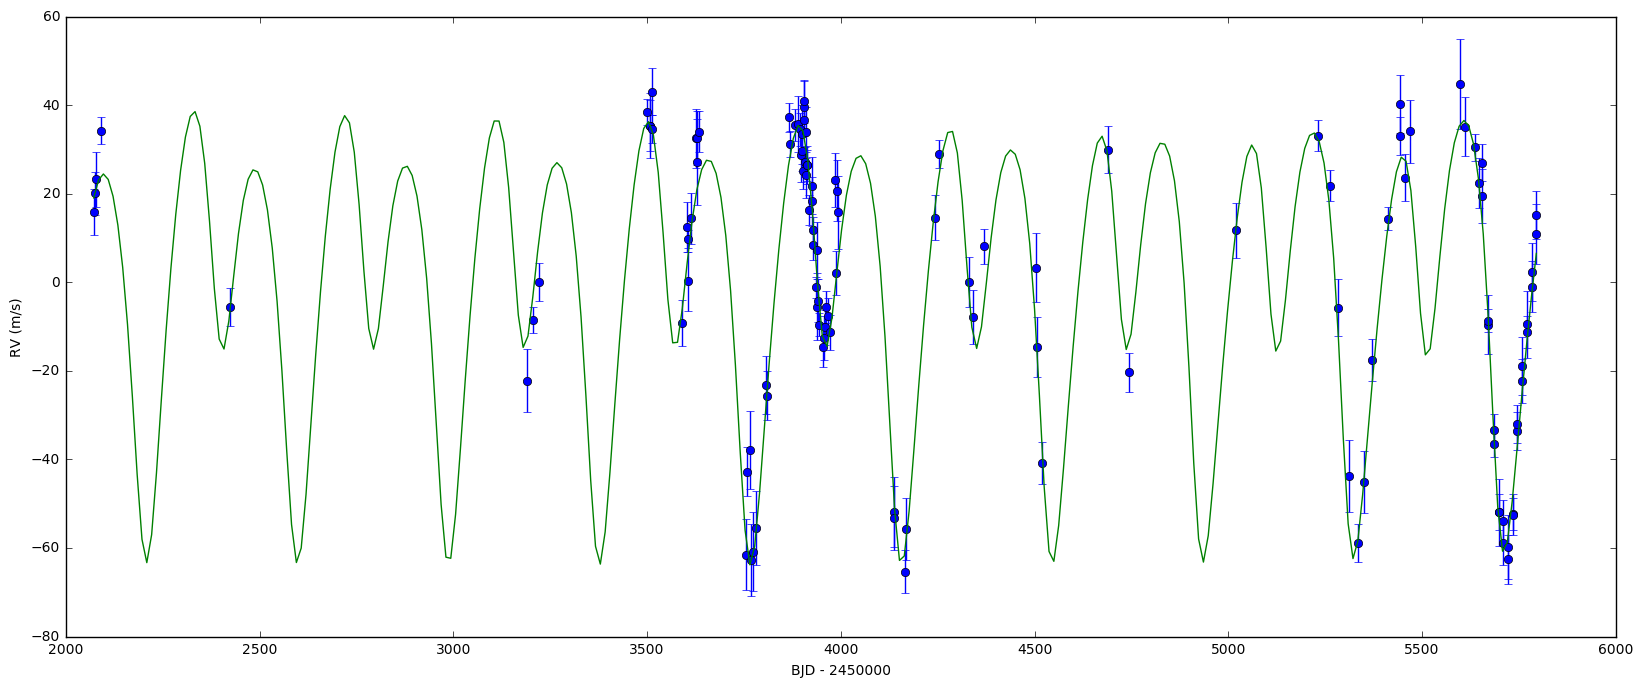

In [6]:
#conv
dtoR = np.pi/180.                          #degrees -> radians

#data
t0 = data["BJD"].iloc[0]
times = data["BJD"] - t0                    #in Barycentric Julian Date (days)
m1sini,m2sini = 0.92907598,0.84091726       #Jupiter masses, default 0.85,0.82
a1,a2 = 0.64141678,1.02299252               #AU, default: 0.64, 1.02
e1,e2 = 0.17145134,0.103073                 #default: 0.17,0.16
w1,w2 = 2.92629096,5.5671592                #in radians, default: 143, 180
M1,M2 = 2.03300709,1.86941606               #in degrees, default: 129, 233

#observer angles - I dont think I need phi, since that just shifts w
sini = 0.32679329                                   #inclination angle (sini = 0-1)

h1,h2 = 0.0366292356588, -0.067656280042    #e*sin(pomega)
k1,k2 = -0.167492868752, 0.0777603440057    #e*cos(pomega)
lambda1,lambda2 = M1+w1, M2+w2
tt = np.linspace(t0,max(data["BJD"]),300)
times = tt - t0

#fit
theta = m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini     #hk

plt.figure(figsize=(20,8))
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.plot(tt,fit_RV(times,theta))
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")
#plt.savefig("fits/MAP_hkfit.png")

print lambda1, lambda2

### emcee

In [4]:
def lnlike(theta_jo, times, y, yerr2, pp_interaction):
    theta, jitter2, offset = theta_jo[:11], theta_jo[-2], theta_jo[-1]               
    model = fit_RV(times, theta, pp_interaction) + offset       #offset to account for any stellar drift
    return -0.5*np.sum( (y - model)**2/(yerr2 + jitter2) + np.log(yerr2 + jitter2) )

def lnprior(theta_jo):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,jitter2,offset = theta_jo
    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.2<a1<0.8 and 0.8<a2<1.4 and 0<=h1**2 + k1**2<1. and 0<=h2**2 + k2**2<1. and -1<h1<1 and -1<h2<1 and -1<k1<1 and -1<k2<1 and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and 0.<jitter2<50. and -40<offset<40:
        return 0   
    return -np.inf 

def lnprob(theta_jo, times, y, yerr2, pp_interaction):
    lnp = lnprior(theta_jo)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta_jo, times, y, yerr2, pp_interaction)

In [5]:
#initialize parameters
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.929,0.841               #Jupiter masses, default 0.85,0.82
a1,a2 = 0.643,1.017                       #AU, default: 0.64, 1.02
h1,h2 = 0.0366,-0.067                     
k1,k2 = -0.167,0.078                      
lambda1,lambda2 = 4.96,1.15               #in radians, default: 129, 233
sini = 0.9                                #inclination angle (0-1)
jitter2 = 10                              #stellar jitter term squared (m^2/s^2)
offset = 0                                #RV offset to account for forward/back motion of star (m/s)
theta_ini = [m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,jitter2,offset]

pp_interaction = 1                        #1=planet-planet interaction, 0=ignore planet-planet interaction

ndim, nwalkers, n_it, n_checkpoints = len(theta_ini), 250, 6000, 6

Run the MCMC. **Warning**. This could take a while. Have periodic checkpoints where you output the progress.

In [5]:
if pp_interaction == 1:
    filename = "hk_%dwalk_%dit"%(nwalkers,n_it)
elif pp_interaction == 0:
    filename = "hksemi-active_%dwalk_%dit"%(nwalkers,n_it)

pos = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, data["RV"].values, (data["Unc"].values)**2, pp_interaction));
for i in range(n_checkpoints):
    pos, _, _ = sampler.run_mcmc(pos, n_it/n_checkpoints);
    np.save(filename+"_chkpt%d.npy"%i,sampler.chain)

NameError: name 'lnprob' is not defined

# Load and analyze data

In [6]:
#Corner plot
burnin, ndim = 500, 13

filename="emcee_chains/hksemi-active_250walk_6000it_chkpt1"
#filename="emcee_chains/best_runs/hk_250walk_6000it/hk_250walk_6000it_chkpt5"

samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


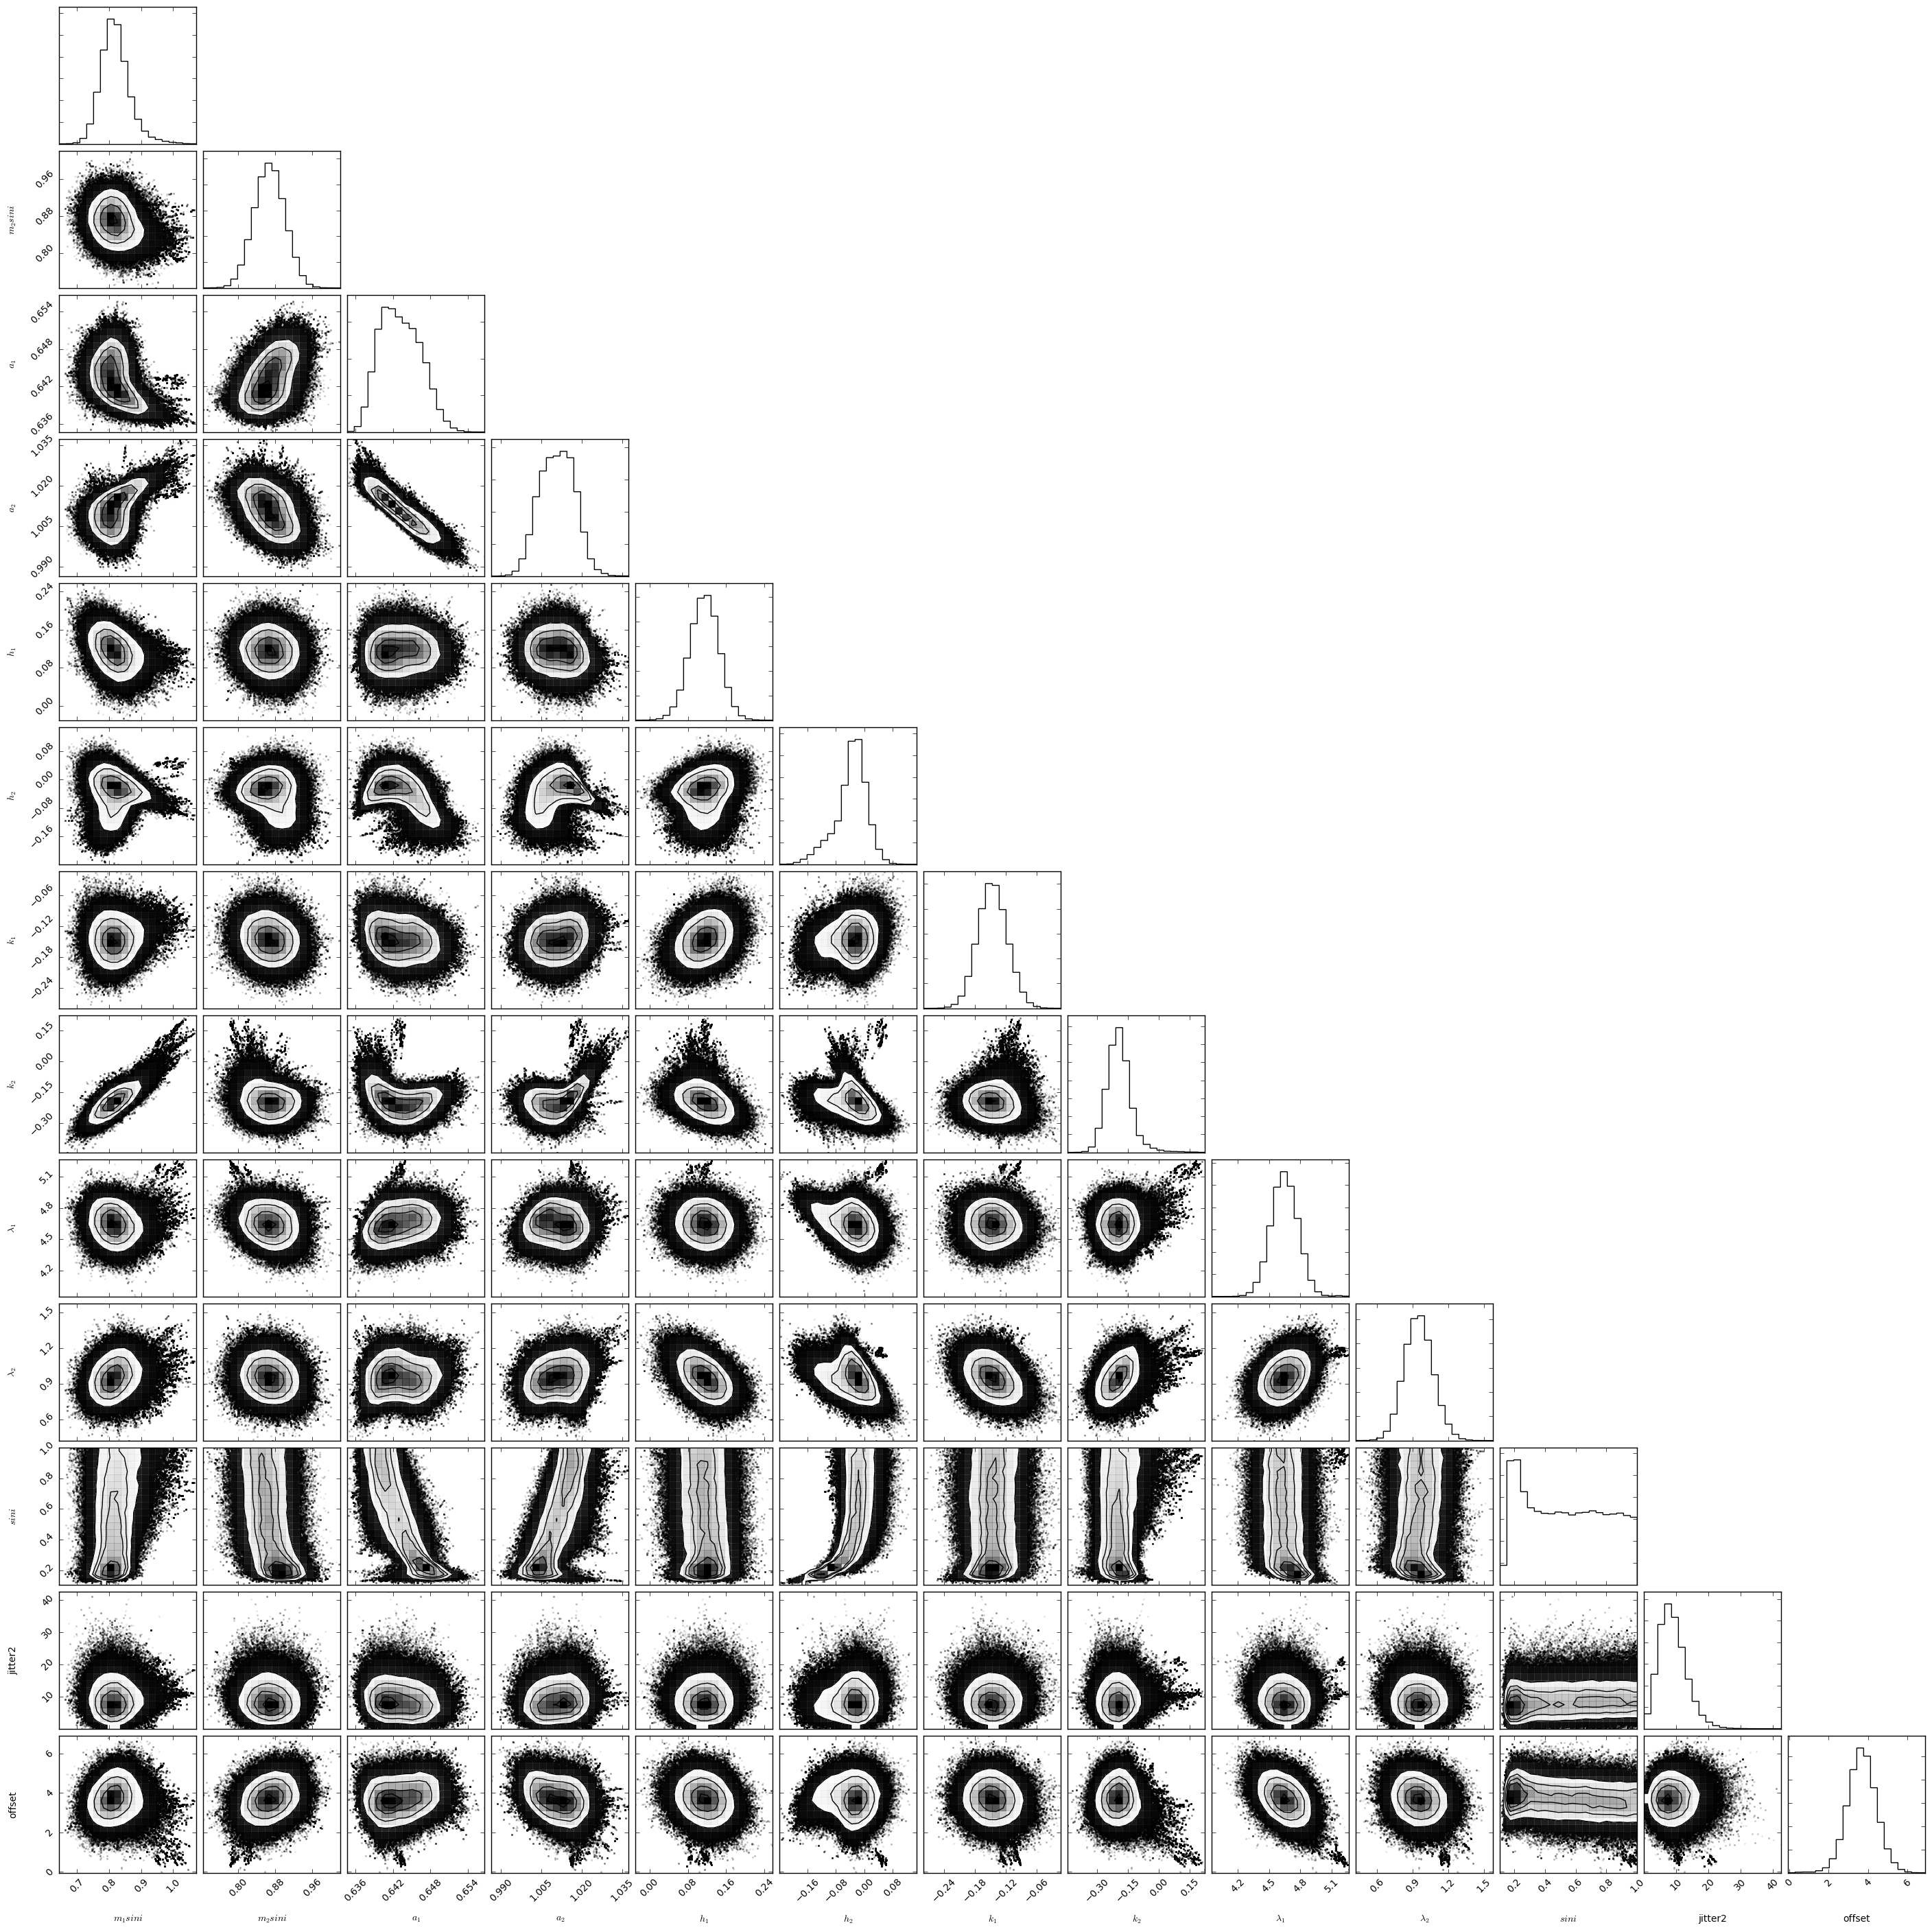

In [7]:
fig = corner.corner(samples, labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$h_1$","$h_2$","$k_1$","$k_2$","$\lambda_1$","$\lambda_2$","$sini$","jitter2","offset"])
fig.savefig(filename+"_corner.png")

### Get/Plot MAP

In [6]:
#MAP result - following emcee example
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambd1","lambd2","sini","jit2","offset"]
MAP = []
MAP_ = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print "parameter \t MAP \t\t upper \t\t lower"
for i in range(ndim):
    print "%s \t\t %.5f \t %.5f \t %.5f"%(labels[i],MAP_[i][0],MAP_[i][1],MAP_[i][2])
    MAP.append(MAP_[i][0])

parameter 	 MAP 		 upper 		 lower
m1sini 		 0.81939 	 0.04566 	 0.03816
m2sini 		 0.86618 	 0.03223 	 0.03185
a1 		 0.64284 	 0.00362 	 0.00319
a2 		 1.01124 	 0.00662 	 0.00676
h1 		 0.11329 	 0.02973 	 0.02990
h2 		 -0.03229 	 0.03405 	 0.04540
k1 		 -0.14508 	 0.02836 	 0.02786
k2 		 -0.19381 	 0.05642 	 0.05037
lambd1 		 4.64449 	 0.12590 	 0.12776
lambd2 		 0.95148 	 0.12006 	 0.11563
sini 		 0.52963 	 0.32428 	 0.28751
jit2 		 8.53972 	 4.49052 	 3.68329
offset 		 3.73970 	 0.71816 	 0.69856


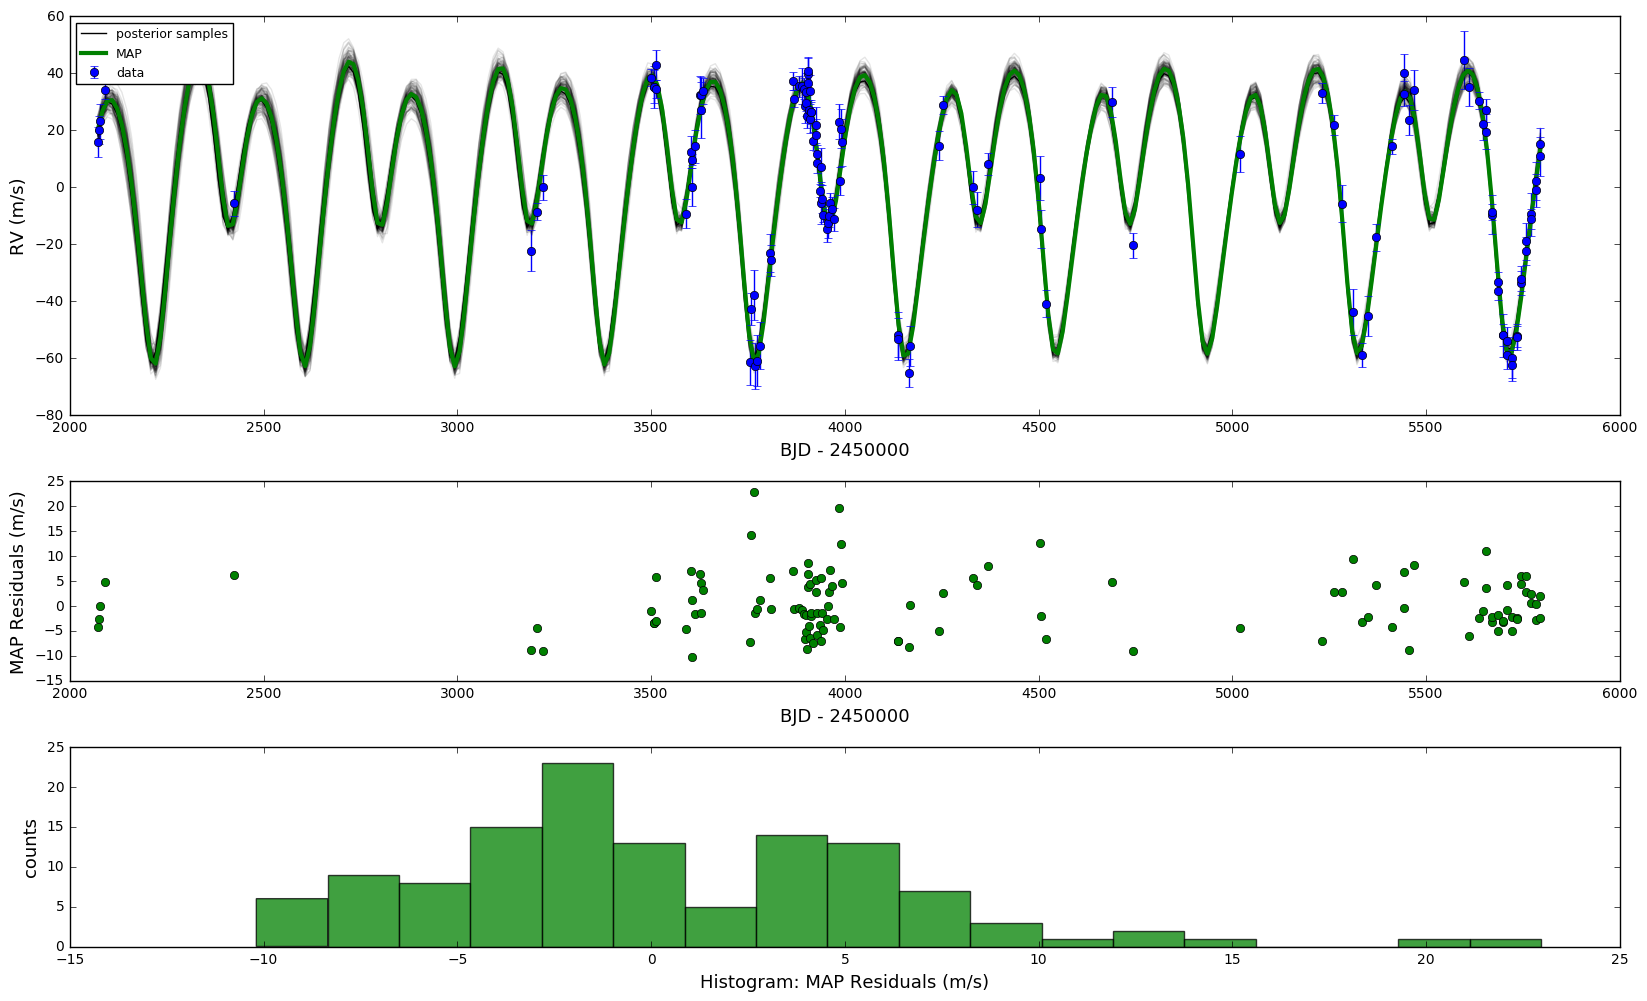

In [47]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.25)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[0].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[2].set_ylabel("counts",fontsize=fontsize)
axes[2].set_xlabel("Histogram: MAP Residuals (m/s)",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:11],pp_interaction) + theta[12]
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:11],pp_interaction) + MAP[12]
Residuals = data["RV"] - (fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:11],pp_interaction) + MAP[12])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')
axes[2].hist(Residuals, 18, facecolor='green', alpha=0.75);

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV.png")

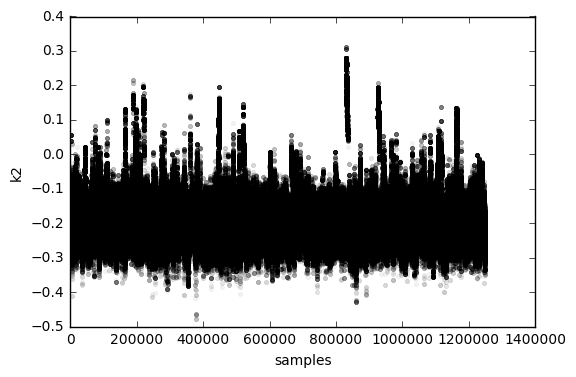

In [11]:
parameter = 7
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambda1","lambda2","sini","jitter2","offset"]
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')
plt.ylabel(labels[parameter])
plt.xlabel("samples")

## Determine if system is in resonance.

In [35]:
#Functions.
from matplotlib import gridspec
def res_arg(sim):
    o1 = sim.particles[1].calculate_orbit(sim.particles[0])
    o2 = sim.particles[2].calculate_orbit(sim.particles[0])
    phi = 2.*o2.l - o1.l - o1.pomega
    phi2 = 2.*o2.l - o1.l - o2.pomega
    phi3 = o1.pomega - o2.pomega
    while(phi >= np.pi):
        phi -= 2*np.pi
    while(phi < -np.pi):
        phi += 2*np.pi
    while(phi2 >= np.pi):
        phi2 -= 2*np.pi
    while(phi2 < -np.pi):
        phi2 += 2*np.pi
    while(phi3 >= np.pi):
        phi3 -= 2*np.pi
    while(phi3 < -np.pi):
        phi3 += 2*np.pi
    return phi, phi2, phi3, o1.a, o1.e, o2.a, o2.e, o2.P/o1.P

#alternate way to check for resonance - max - min
def is_in_res_maxmin(ph1,ph2,ph3): #default range is -pi to pi
    angle_for_res = np.pi/4        #if this angle is devoid of samples, system is librating and considered in res
    ir = []                        #"in resonance" array, one for each resonant angle
    phi = [ph1,ph2,ph3]
    for p in phi:
        R = []
        R.append(np.max(p) - np.min(p))
        while np.any(p<0):
            p[p<0] += 2*np.pi      #convert to 0-2pi range
        R.append(np.max(p) - np.min(p))
        if np.min(R) < 2*np.pi - angle_for_res:
            ir.append(1)
        else:
            ir.append(0)
    return ir[0], ir[1], ir[2]

def is_in_resonance(ph1, ph2, ph3):
    angle_for_res = np.pi/4       #if this angle is devoid of samples, system is librating and considered in res
    ir = []                       #"in resonance" array, one for each resonant angle
    phi = [ph1,ph2,ph3]
    bins = 36                     #converting 2*pi radians into this many bins
    for p in phi:
        hist, bin_r = np.histogram(p,bins=bins,range=(-np.pi, np.pi))  #bin resonant angles
        histx2 = np.concatenate((hist,hist))  #run over twice so it wraps around and there's no discontinuity
        max_consecutive_empty_bins = 0
        current_consecutive_empty_bins = 0
        for h in histx2:         #find largest number of consecutive empty bins
            if h == 0:
                current_consecutive_empty_bins += 1
            else:
                if current_consecutive_empty_bins > max_consecutive_empty_bins:
                    max_consecutive_empty_bins = current_consecutive_empty_bins
                current_consecutive_empty_bins = 0
        if max_consecutive_empty_bins > round(0.5*angle_for_res*bins/np.pi):  #condition for resonance
            ir.append(1)
        else:
            ir.append(0)
    return ir[0], ir[1], ir[2]

def check_resonance(theta,times):
    m1sini,m2sini,aa1,aa2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    phi1, phi2, phi3, a1, e1, a2, e2, Pr = [], [], [], [], [], [], [], []
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* aa1**(1.5) / 25.    #dt = 25 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=aa1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=aa2,l=lambda2,h=h2,k=k2) 
    #sim.testparticle_type = 1            #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    #sim.N_active = sim.N                 #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    sim.move_to_com()
    for t in times:
        sim.integrate(t)
        p1,p2,p3,sma1,ecc1,sma2,ecc2,Pratio = res_arg(sim)
        phi1.append(p1),phi2.append(p2),phi3.append(p3),a1.append(sma1),e1.append(ecc1),a2.append(sma2),e2.append(ecc2), Pr.append(Pratio)
    #ir1, ir2, ir3 = is_in_resonance(phi1, phi2, phi3)
    ir1, ir2, ir3 = is_in_res_maxmin(phi1, phi2, phi3)
    return phi1, phi2, phi3, a1, e1, a2, e2, Pr, ir1, ir2, ir3

fraction of phi1, phi2, phi3 angles librating: 0.99 +/- 0.10, 0.09 +/- 0.10, 0.10 +/- 0.10


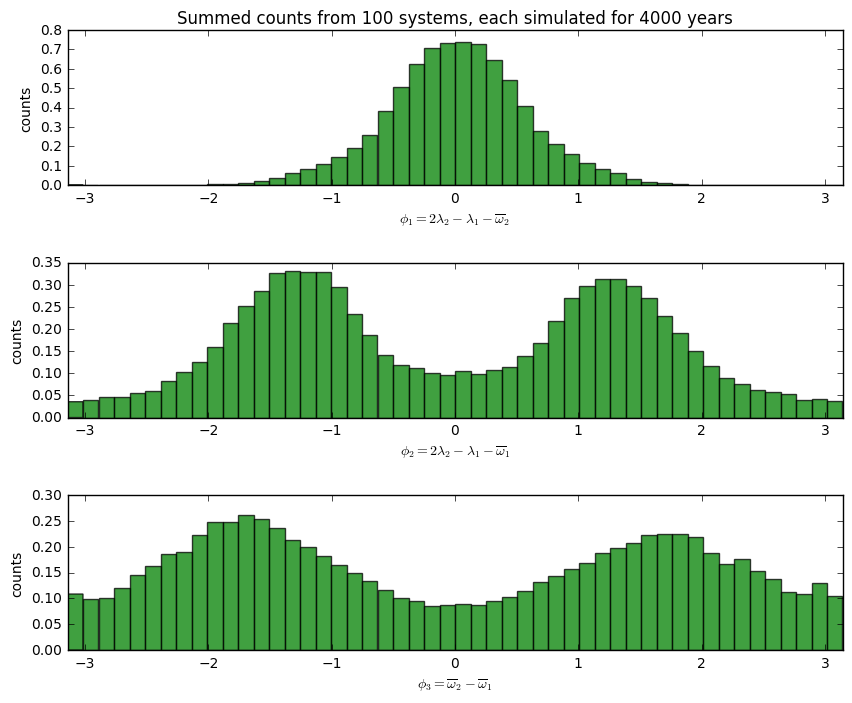

In [36]:
#Run. Draw samples and see if system is in resonance
Ndraws = 100                   #number of simulations
tmax = 4000                  #length of each simulation
Npts = 1000                  #number of outputted points per simulation
plot_singles = 0             #plot resonant angles of individual runs
times = np.linspace(0,tmax,Npts)

phi1 = []
phi2 = []
phi3 = []
in_res1 = []
in_res2 = []
in_res3 = []
fontsize=13
i=0
for theta in samples[np.random.randint(len(samples), size=Ndraws)]:
    p1, p2, p3, a1, e1, a2, e2, Pratio, ir1, ir2, ir3 = check_resonance(theta[:11],times)
    phi1 = phi1 + p1
    phi2 = phi2 + p2
    phi3 = phi3 + p3
    in_res1.append(ir1)
    in_res2.append(ir2)
    in_res3.append(ir3)
    if plot_singles == 1:
        fig = plt.figure(figsize=(10, 8));
        gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]);
        axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])];
        axes[0].plot(times,p3, '.', label=r'$\phi_3 = \overline{\omega}_2 - \overline{\omega}_1$');
        axes[0].plot(times,p2, '.', label=r'$\phi_2 = 2\lambda_2 - \lambda_1 - \overline{\omega}_1$');
        axes[0].plot(times,p1, '.', label=r'$\phi_1 = 2\lambda_2 - \lambda_1 - \overline{\omega}_2$');
        axes[1].plot(times,e1, '.', label='planet 1');
        axes[1].plot(times,e2, '.', label='planet 2');
        axes[2].plot(times,Pratio, '.', label='planet 1');
        #axes[2].plot(times,a1, '.', label='planet 1');
        #axes[2].plot(times,a2, '.', label='planet 2');
        #axes[2].legend(loc="upper left", numpoints=1, fontsize=8)
        axes[0].legend(loc="upper left", numpoints=1, fontsize=8);
        axes[0].set_ylabel("resonant arguments");
        axes[1].set_ylabel("eccentricity");
        axes[1].legend(loc="upper left", numpoints=1, fontsize=8);
        axes[2].set_ylabel("P2/P1");
        axes[2].set_xlabel('time (years)');
        plt.savefig(filename+"_res%d"%i);
        i += 1
        plt.clf();
        
#plot
bins = 50
fig = plt.figure(figsize=(10, 8));
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]);
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])];
plt.subplots_adjust(hspace = 0.5);
axes[0].hist(phi1, bins, normed=1, range=(-np.pi, np.pi), facecolor='green', alpha=0.75);
axes[1].hist(phi2, bins, normed=1, range=(-np.pi, np.pi), facecolor='green', alpha=0.75);
axes[2].hist(phi3, bins, normed=1, range=(-np.pi, np.pi), facecolor='green', alpha=0.75);
axes[0].set_xlabel(r'$\phi_1 = 2\lambda_2 - \lambda_1 - \overline{\omega}_2$');
axes[1].set_xlabel(r'$\phi_2 = 2\lambda_2 - \lambda_1 - \overline{\omega}_1$');
axes[2].set_xlabel(r'$\phi_3 = \overline{\omega}_2 - \overline{\omega}_1$');
axes[0].set_title('Summed counts from %d systems, each simulated for %d years'%(Ndraws,tmax));
axes[0].set_ylabel('counts');
axes[1].set_ylabel('counts');
axes[2].set_ylabel('counts');
axes[0].set_xlim([-np.pi,np.pi]);
axes[1].set_xlim([-np.pi,np.pi]);
axes[2].set_xlim([-np.pi,np.pi]);
plt.savefig(filename+'_rescheck.png');
count1, count2, count3, err = np.sum(in_res1)/float(Ndraws), np.sum(in_res2)/float(Ndraws), np.sum(in_res3)/float(Ndraws), np.sqrt(Ndraws)/Ndraws
print r"fraction of phi1, phi2, phi3 angles librating: %.2f +/- %.2f, %.2f +/- %.2f, %.2f +/- %.2f"%(count1,err,count2,err,count3,err)

## Convert from Pal coords to standard orbital elements (to compare to Robertson 2012)

In [8]:
#convert MAP_ estimate to orbital elements *WITH* error bars
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambd1","lambd2","sini","jit2","offset"]
labels_orb=["m1sini","m2sini","a1","a2","e1","e2","w1","w2","M1","M2","sini","jit2","offset"]
MAP_ = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
e1,e2 = np.sqrt(MAP_[4][0]**2+MAP_[6][0]**2), np.sqrt(MAP_[5][0]**2+MAP_[7][0]**2)
w1,w2 = np.arccos(MAP_[6][0]/e1), np.arccos(MAP_[7][0]/e2)
M1,M2 = MAP_[8][0] - w1, MAP_[9][0] - w2
#MAP_orb = MAP_orb + [e1,e2,w1*180/np.pi,w2*180/np.pi,M1*180/np.pi,(M2+2*np.pi)*180/np.pi,MAP_[10][0],MAP_[11][0],MAP_[12][0]]

#get those pesky error bars
e1up,e1low = 0.5*np.sqrt((2*MAP_[4][1]*MAP_[4][0])**2 +(2*MAP_[6][1]*MAP_[6][0])**2)/e1, 0.5*np.sqrt((2*MAP_[4][2]*MAP_[4][0])**2 +(2*MAP_[6][2]*MAP_[6][0])**2)/e1
e2up,e2low = 0.5*np.sqrt((2*MAP_[5][1]*MAP_[5][0])**2 +(2*MAP_[7][1]*MAP_[7][0])**2)/e2, 0.5*np.sqrt((2*MAP_[5][2]*MAP_[5][0])**2 +(2*MAP_[7][2]*MAP_[7][0])**2)/e2
w1up,w1low = np.sqrt(( (e1*MAP_[4][1])**2 + (MAP_[4][0]*e1up)**2 )/(1-(MAP_[4][0]/e1)**2) )/e1**2, np.sqrt(( (e1*MAP_[4][2])**2 + (MAP_[4][0]*e1up)**2 )/(1-(MAP_[4][0]/e1)**2) )/e1**2
w2up,w2low = np.sqrt(( (e2*MAP_[5][1])**2 + (MAP_[5][0]*e2up)**2 )/(1-(MAP_[5][0]/e2)**2) )/e2**2, np.sqrt(( (e2*MAP_[5][2])**2 + (MAP_[5][0]*e2up)**2 )/(1-(MAP_[5][0]/e2)**2) )/e2**2
M1up,M1low = np.sqrt(MAP_[8][1]**2 + w1up**2), np.sqrt(MAP_[8][2]**2 + w1low**2)
M2up,M2low = np.sqrt(MAP_[9][1]**2 + w2up**2), np.sqrt(MAP_[9][2]**2 + w2low**2)

r2d = 180/np.pi
MAP_orb = MAP_[0:4] + [(e1,e1up,e1low),(e2,e2up,e2low),(w1*r2d,w1up*r2d,w1low*r2d),(w2*r2d,w2up*r2d,w2low*r2d),(M1*r2d,M1up*r2d,M1low*r2d),(M2*r2d,M2up*r2d,M2low*r2d)] + MAP_[10:]

print "parameter \t MAP \t\t upper \t\t lower"
for i in range(ndim):
    print "%s \t\t %.5f \t %.5f \t %.5f"%(labels_orb[i],MAP_orb[i][0],MAP_orb[i][1],MAP_orb[i][2])

parameter 	 MAP 		 upper 		 lower
m1sini 		 0.81641 	 0.04388 	 0.03825
m2sini 		 0.86789 	 0.03316 	 0.03299
a1 		 0.64297 	 0.00368 	 0.00311
a2 		 1.01102 	 0.00636 	 0.00677
e1 		 0.18574 	 0.02900 	 0.02867
e2 		 0.19853 	 0.05346 	 0.05101
w1 		 141.74346 	 13.56948 	 13.80235
w2 		 171.03381 	 10.09593 	 14.45364
M1 		 124.49897 	 15.44073 	 15.50325
M2 		 -116.56225 	 12.27531 	 15.94382
sini 		 0.52695 	 0.31866 	 0.29448
jit2 		 8.50984 	 4.54042 	 3.64923
offset 		 3.70090 	 0.71051 	 0.70035


## Old Resonance functions

In [14]:
def res_arg(sim):
    o1 = sim.particles[1].calculate_orbit(sim.particles[0])
    o2 = sim.particles[2].calculate_orbit(sim.particles[0])
    phi = 2.*o2.l - o1.l - o1.pomega
    phi2 = 2.*o2.l - o1.l - o2.pomega
    phi3 = o1.pomega - o2.pomega
    while(phi >= 2*np.pi):
        phi -= 2*np.pi
    while(phi < 0.):
        phi += 2*np.pi
    while(phi2 >= 2*np.pi):
        phi2 -= 2*np.pi
    while(phi2 < 0.):
        phi2 += 2*np.pi
    while(phi3 >= 2*np.pi):
        phi3 -= 2*np.pi
    while(phi3 < 0.):
        phi3 += 2*np.pi
    return phi, phi2, phi3, o1.a, o1.e, o2.a, o2.e, o2.P/o1.P

def check_resonance(theta,times):
    m1sini,m2sini,aa1,aa2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    phi, phi2, phi3, a1, e1, a2, e2, Pr = [], [], [], [], [], [], [], []
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* aa1**(1.5) / 25.    #dt = 25 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=aa1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=aa2,l=lambda2,h=h2,k=k2) 
    #sim.testparticle_type = 1            #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    #sim.N_active = sim.N                 #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    sim.move_to_com()
    for t in times:
        sim.integrate(t)
        p1,p2,p3,sma1,ecc1,sma2,ecc2,Pratio = res_arg(sim)
        phi.append(p1),phi2.append(p2),phi3.append(p3),a1.append(sma1),e1.append(ecc1),a2.append(sma2),e2.append(ecc2), Pr.append(Pratio)
    return phi, phi2, phi3, a1, e1, a2, e2, Pr